# Análise Exploratória de Dados Básica - Informações Cadastrais CVM

## 1 - Introdução

<p> O objetivo deste notebook é utilizar ferramentas de análise de dados (notadamente com o auxílio da linguagem python) aplicadas a um tema de interesse específico. O mercado financeiro / de capitais, devido a sua natureza de constante e volumosa produção de dados, é área rica para tais tipos de investigação. </p>
     

<p> Utilizaremos uma pequena fração de dados públicos abertos como fonte de estudos. Tratam-se das informações cadastrais dos fundos de investimento brasileiros regidos pela Instrução CVM 555. Este dataset fornece dados como a classe, situação, nome do gestor, administrador, valor do patrimônio líquido, dentre tantas outras que serão melhor exploradas no decorrer deste breve trabalho. </p>
    

<p> Vale destacar as fontes destes dados. Os mesmos foram obtidos do Portal de Dados Abertos da CVM (órgão regulador do mercado de capitais brasileiro), onde podem ser encontrados outros conjuntos de dados sobre fundos de investimento 555, fundos estruturados, dados de companhias abertas, entre outros. Para quem se interessa pelo tema, esta é valiosa fonte de informação. </p>
    
    
<p> A seguir, seguem as fontes dos dados utilizadas neste artigo:<p> 
    
    
* Portal Dados Abertos CVM:    

    http://dados.cvm.gov.br/organization/cvm
    
        
* Conjunto de dados 'Fundos de Investimento: Informação Cadastral':

    http://dados.cvm.gov.br/dataset/fi-cad

## 1 - Transformação e limpeza dos dados

<p> Vamos iniciar importando as bibliotecas relevantes: </p>

In [1]:
import pandas as pd
import timeit
import numpy as np
import os
import psycopg2
import psycopg2.extras
import itertools as itr
import seaborn as sns
import matplotlib.pyplot as plt
import re
%matplotlib inline

<p> Em seguida realizamos o download do arquivo .csv para um dataframe. Utilizamos ";" como separador dos dados e encoding "latin_1" para que caracteres como "~", "ç", entre outros, sejam corretamente processados. Apresentamos então os 5 primeiros registros utilizando o método head (.head())  </p>

In [2]:
url = "http://dados.cvm.gov.br/dados/FI/CAD/DADOS/inf_cadastral_fi_20200331.csv"

info_cadastral_555 = pd.read_csv(url, sep =';', encoding = 'latin_1')

info_cadastral_555.head()

,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,DT_INI_EXERC,DT_FIM_EXERC,...,ADMIN,PF_PJ_GESTOR,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR
0,33.913.620/0001-70,051 BRUCUTU FUNDO DE INVESTIMENTO MULTIMERCADO...,2019-07-19,2019-06-04,NaN,EM FUNCIONAMENTO NORMAL,2019-08-05,2019-08-05,2019-08-05,2020-05-31,...,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...,PJ,30.193.705/0001-33,ZERO CINCO UM CAPITAL GESTÃO DE RECURSOS LTDA,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,62.318.407/0001-19,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...,62.318.407/0001-19,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...
1,24.498.658/0001-33,051 CAJUINA FUNDO DE INVESTIMENTO DE ACOES,2020-03-16,2020-03-16,NaN,EM FUNCIONAMENTO NORMAL,2020-03-16,2020-03-16,2020-03-16,2020-06-30,...,BTG PACTUAL SERVIÇOS FINANCEIROS S/A DTVM,PJ,30.193.705/0001-33,ZERO CINCO UM CAPITAL GESTÃO DE RECURSOS LTDA,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,30.306.294/0001-45,BANCO BTG PACTUAL S/A,59.281.253/0001-23,BTG PACTUAL SERVIÇOS FINANCEIROS S/A DTVM
2,31.964.019/0001-81,051 CAPITAL - COLORADO FUNDO DE INVESTIMENTO M...,2018-11-29,2018-11-27,NaN,EM FUNCIONAMENTO NORMAL,2018-12-10,2018-12-10,2019-07-01,2020-06-30,...,BTG PACTUAL SERVIÇOS FINANCEIROS S/A DTVM,PJ,30.193.705/0001-33,ZERO CINCO UM CAPITAL GESTÃO DE RECURSOS LTDA,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,30.306.294/0001-45,BANCO BTG PACTUAL S/A,59.281.253/0001-23,BTG PACTUAL SERVIÇOS FINANCEIROS S/A DTVM
3,30.509.213/0001-04,051 CARIBE FUNDO DE INVESTIMENTO MULTIMERCADO ...,2019-06-11,2018-04-13,NaN,EM FUNCIONAMENTO NORMAL,2019-06-25,2019-06-25,2020-02-01,2021-01-31,...,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...,PJ,30.193.705/0001-33,ZERO CINCO UM CAPITAL GESTÃO DE RECURSOS LTDA,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,62.318.407/0001-19,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...,62.318.407/0001-19,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...
4,36.248.874/0001-00,051 CP ALLOCATION FI EM COTAS DE FUNDOS DE INV...,2020-03-03,2020-03-03,NaN,FASE PRÉ-OPERACIONAL,2020-03-03,NaN,NaN,NaN,...,BTG PACTUAL SERVIÇOS FINANCEIROS S/A DTVM,PJ,30.193.705/0001-33,ZERO CINCO UM CAPITAL GESTÃO DE RECURSOS LTDA,61.366.936/0001-25,ERNST & YOUNG AUDITORES INDEPENDENTES S/S,30.306.294/0001-45,BANCO BTG PACTUAL S/A,59.281.253/0001-23,BTG PACTUAL SERVIÇOS FINANCEIROS S/A DTVM


<p> É possível observar que o arquivo traz considerável quantidade de dados. Nosso objetivo até o final deste notebook é obter um profundo entendimento sobre os mesmos e, consequentemente, obter um panorama atual da indústria de fundos de investimento brasileira. 
    
<p> Vamos identificar quais os atributos (colunas da tabela) sobre cada fundo (registros ou linhas da tabela) o arquivo fornece com o código a seguir: </p>

In [3]:
pd.DataFrame(info_cadastral_555.columns, columns = ["Colunas"])

,Colunas
0,CNPJ_FUNDO
1,DENOM_SOCIAL
2,DT_REG
3,DT_CONST
4,DT_CANCEL
5,SIT
6,DT_INI_SIT
7,DT_INI_ATIV
8,DT_INI_EXERC
9,DT_FIM_EXERC


<p> Com o método .info() a seguir é possível obter um resumo interessante sobre a estrutura de nosso dataset. </p>

<p> Podemos observar que se trata de dataset com 36 colunas (atributos) e 36.464 linhas (registros), o qual ocupa pouco mais de 10 MB de espaço de memória. Além disso, obtemos a listagem com o nome das colunas, a quantidade de registros não-nulos naquela coluna específica e seu respectivo tipo de dado. "Object" em geral se referem a colunas texto e "float64" referem-se a colunas com dados numéricos não-inteiros, com casas decimais.</p>
    
<p> Por exemplo, a coluna "CNPJ_FUNDO" armazena dados em texto (object) e contém 36.464 registros não nulos. Isto quer dizer, portanto, que a mesma não apresenta valores em banco / nulos, visto que o total de registros no dataset é de igualmente 36.464. </p>
    
<p> Ao final da tabela é possível observar que a mesma é composta por 3 colunas com dados numéricos (float64) e 33 com dados de texto (object). </p>

In [4]:
info_cadastral_555.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36464 entries, 0 to 36463
Data columns (total 36 columns):
CNPJ_FUNDO          36464 non-null object
DENOM_SOCIAL        36464 non-null object
DT_REG              36464 non-null object
DT_CONST            36464 non-null object
DT_CANCEL           17536 non-null object
SIT                 36463 non-null object
DT_INI_SIT          36463 non-null object
DT_INI_ATIV         33996 non-null object
DT_INI_EXERC        33755 non-null object
DT_FIM_EXERC        33755 non-null object
CLASSE              36461 non-null object
DT_INI_CLASSE       36461 non-null object
RENTAB_FUNDO        29781 non-null object
CONDOM              36460 non-null object
FUNDO_COTAS         36464 non-null object
FUNDO_EXCLUSIVO     36462 non-null object
TRIB_LPRAZO         27968 non-null object
INVEST_QUALIF       36461 non-null object
TAXA_PERFM          21605 non-null float64
INF_TAXA_PERFM      2383 non-null object
TAXA_ADM            21815 non-null float64
INF_TAXA

<p> Apesar de já bastante informativo, podemos tratar este dataset para que o mesmo no traga informações de maior qualidade. </p>

<p> Ainda no Portal de Dados Abertos da CVM é possível obter o "Dicionário de Dados" para o arquivo analisado. O mesmo apresenta descrição detalhada, tipo de dados e tamanho de cada coluna do dataset. Tal dicionário pode ser encontrado no link abaixo: </p>

http://dados.cvm.gov.br/dados/FI/CAD/META/meta_inf_cadastral_fi.txt

<p> Vamos na linha de código abaixo renomear as colunas do nosso dataset e alterar os tipos de dados das mesmas para que reflitam a estrutura do dicionário de dados. </p>

In [5]:
tipos_colunas = {'CNPJ_FUNDO':'object','DENOM_SOCIAL':'object','DT_REG':'datetime64','DT_CONST':'datetime64', 'DT_CANCEL':'datetime64',
                 'SIT':'object', 'DT_INI_SIT':'datetime64', 'DT_INI_ATIV':'datetime64', 'DT_INI_EXERC':'datetime64',
                    'DT_FIM_EXERC':'datetime64', 'CLASSE':'object', 'DT_INI_CLASSE':'datetime64', 'RENTAB_FUNDO':'object',
                 'CONDOM':'object', 'FUNDO_COTAS':'object', 'FUNDO_EXCLUSIVO':'object', 'TRIB_LPRAZO':'object', 
                 'INVEST_QUALIF':'object',
                    'TAXA_PERFM':'float64', 'INF_TAXA_PERFM':'object', 'TAXA_ADM':'float64', 'INF_TAXA_ADM':'object',
                 'VL_PATRIM_LIQ':'float64', 'DT_PATRIM_LIQ':'datetime64', 'DIRETOR':'object',
                 'CNPJ_ADMIN':'object', 'ADMIN':'object', 'PF_PJ_GESTOR':'object', 'CPF_CNPJ_GESTOR':'object', 
                 'GESTOR':'object', 'CNPJ_AUDITOR':'object',
                    'AUDITOR':'object', 'CNPJ_CUSTODIANTE':'object', 'CUSTODIANTE':'object', 'CNPJ_CONTROLADOR':'object',
                 'CONTROLADOR':'object'}

nomes_colunas = {'CNPJ_FUNDO':'CNPJ do fundo', 'DENOM_SOCIAL':'Denominação Social','DT_REG':'Data de registro',
                    'DT_CONST':'Data de constituição', 'DT_CANCEL':'Data de cancelamento','SIT':'Situação',
                    'DT_INI_SIT':'Data início da situação', 'DT_INI_ATIV':'Data de início de atividade',
                    'DT_INI_EXERC':'Data início do exercício social', 'DT_FIM_EXERC':'Data fim do exercício social',
                    'CLASSE':'Classe', 'DT_INI_CLASSE':'Data de início na classe', 'RENTAB_FUNDO':'Forma de rentabilidade do fundo (indicador de desempenho)',
                    'CONDOM':'Forma de condomínio', 'FUNDO_COTAS':'Fundo de cotas?', 'FUNDO_EXCLUSIVO':'Fundo exclusivo?',
                    'TRIB_LPRAZO':'Tributação de longo prazo?', 'INVEST_QUALIF':'investidor qualificado?', 'TAXA_PERFM':'Taxa de performance',
                 'INF_TAXA_PERFM':'Informações Adicionais (Taxa de performance)', 'TAXA_ADM':'Taxa de administração', 'INF_TAXA_ADM':'Informações Adicionais (Taxa de administração)',
                    'VL_PATRIM_LIQ':'Valor do patrimônio líquido', 'DT_PATRIM_LIQ':'Data do patrimônio líquido',
                    'DIRETOR':'Nome do Diretor Responsável', 'CNPJ_ADMIN':'CNPJ do Administrador', 'ADMIN':'Nome do Administrador',
                    'PF_PJ_GESTOR':'PF / PJ?', 'CPF_CNPJ_GESTOR':'Código de identificação do gestor CPF/CNPJ',
                    'GESTOR':'Nome do Gestor', 'CNPJ_AUDITOR':'CNPJ do Auditor', 'AUDITOR':'Nome do Auditor',
                'CNPJ_CUSTODIANTE':'CNPJ do Custodiante', 'CUSTODIANTE':'Nome do Custodiante', 'CNPJ_CONTROLADOR':'CNPJ do Controlador',
                 'CONTROLADOR':'Nome do Controlador'}
                                             
info_cadastral_555 = info_cadastral_555.astype(tipos_colunas)    
info_cadastral_555 = info_cadastral_555.rename(columns=nomes_colunas)
    
info_cadastral_555.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36464 entries, 0 to 36463
Data columns (total 36 columns):
CNPJ do fundo                                                36464 non-null object
Denominação Social                                           36464 non-null object
Data de registro                                             36464 non-null datetime64[ns]
Data de constituição                                         36464 non-null datetime64[ns]
Data de cancelamento                                         17536 non-null datetime64[ns]
Situação                                                     36463 non-null object
Data início da situação                                      36463 non-null datetime64[ns]
Data de início de atividade                                  33996 non-null datetime64[ns]
Data início do exercício social                              33755 non-null datetime64[ns]
Data fim do exercício social                                 33755 non-null datetime64[ns]
Class

<p> Ao comparar o output deste método .info() com o anterior, podemos constatar que o nome das colunas assim exposto é mais claro / auto-explicativo, nos ajudando assim na sequência de nossa análise. Ademais, nota-se que agora 9 das colunas apresentam tipo de dados como "datetime64". São colunas referentes a datas que inicialmente o python decodificou ou "entendeu" como texto e que alteramos em seguida. </p>
    
<p> Um último destaque antes de avançarmos é que poderíamos ter indicado, logo quando lemos o arquivo através do método .read_csv(), parâmetros de tipo (dtype = [] ou {:} e nome (names = []) das colunas, assim como indicação daquelas que deveriam ser lidas como datas (parse_dates = []). optamos pela abordagem feita para fins ilustrativos. </p> 
    
<p> Nosso conjunto de dados agora está melhor formatado e está pronto para a etapa seguinte. </p>

## 3 - Análise exploratória dos dados

### 3.1 - Todas as variáveis

<p> Nesta seção iremos analisar em maior detalhe as informações contidas em cada coluna e as relações entre as mesmas com o intuito de obter insights referentes à industria de fundos de investimento brasileira. </p>

<p> Apesar do método .info() utilizado anteriormente nos mostrar o valor absoluto de registros não-nulos para cada coluna, em geral é mais informativo apresentar este dado como uma porcentagem do total de registros. </p>

<p> É isto o que faremos no código a seguir: </p>

In [15]:
valores_ausentes = pd.DataFrame(columns = ['Quantidade', 'Percentual %'], index = info_cadastral_555.columns)

for coluna in info_cadastral_555.columns:
    valores_ausentes.loc[coluna, 'Percentual %'] = (1 - (info_cadastral_555[coluna].count() / 
                                                         info_cadastral_555[coluna].size)).round(5) * 100
    valores_ausentes.loc[coluna, 'Quantidade'] = info_cadastral_555[coluna].isnull().sum()
    
valores_ausentes

,Quantidade,Percentual %
CNPJ do fundo,0,0
Denominação Social,0,0
Data de registro,0,0
Data de constituição,0,0
Data de cancelamento,18928,51.909
Situação,1,0.003
Data início da situação,1,0.003
Data de início de atividade,2468,6.768
Data início do exercício social,2709,7.429
Data fim do exercício social,2709,7.429


<p> Podemos assim melhor perceber a diversidade de nosso dataset. Enquanto determinadas colunas não apresentam valores nulos, como "CNPJ do fundo", "Denominação Social", "Situação", "Classe", outras como "Informações Adicionais (Taxa de performance)" e "Informações Adicionais (Taxa de administração)" apresentam poucos registros preenchidos. </p>

<p> O entendimento de valores nulos é etapa importante na análise de dados. O conhecimento do tema em estudo ajuda a compreender a razão destes ocorrerem. Os elevados percentuais de valores nulos referentes a taxa de administração e de performance podem se referir a fundos que não apresentam estas taxas ou de fato informações ausentes. Apenas uma análise mais aprofundada pode entender as razões destes valores nulos existirem. </p>

<p> Algo que chama atenção são os percentuais muito parecidos das últimas 11 colunas listadas acima (de "CNPJ do administrador" até "Nome do controlador"), em cerca de 34,4% de valores nulos. Existe algum padrão para que todas estas colunas apresentem o mesmo percentual? Seriam tais valores ausentes referentes a fundos encerrados, razão para que hoje de fato não apresentem administrador, gestor, custodiante, etc? Porém, ao observar a coluna "Data de cancelamento" o percentual é de 51,9%. Se a hipótese anterior estivesse correta, os valores não deveriam ser ao menos próximos? 
    
<p> Estas são respostas que poderemos obter ao cruzar com os dados da coluna "Situação". Porém, por enquanto, estamos analisando colunas em separado, quando analisarmos 2 ou mais colunas simultaneamente iremos relembrar estas questões.</p>

<p> Ao obtermos um novo dataset, seja de qual fonte for, é importante analisarmos a consistência e a qualidade dos dados reportados. </p>
    
<p> Primeiramente vamos avaliar se existem registros duplicados com o seguinte código: </p>

In [9]:
dup = info_cadastral_555[info_cadastral_555.duplicated()]
dup

,CNPJ do fundo,Denominação Social,Data de registro,Data de constituição,Data de cancelamento,Situação,Data início da situação,Data de início de atividade,Data início do exercício social,Data fim do exercício social,...,Nome do Administrador,PF / PJ?,Código de identificação do gestor CPF/CNPJ,Nome do Gestor,CNPJ do Auditor,Nome do Auditor,CNPJ do Custodiante,Nome do Custodiante,CNPJ do Controlador,Nome do Controlador
8779,27.292.836/0001-63,CIBRIUS FUNDO DE INVESTIMENTO MULTIMERCADO CRÉ...,2017-06-02,2017-02-21,NaT,EM FUNCIONAMENTO NORMAL,2017-07-11,2017-07-11,2019-08-01,2020-07-31,...,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...,PJ,00.531.590/0001-89,CIBRIUS - INSTITUTO CONAB DE SEGURIDADE SOCIAL,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,62.318.407/0001-19,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...,62.318.407/0001-19,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...
8781,27.292.841/0001-76,CIBRIUS FUNDO DE INVESTIMENTO RENDA FIXA,2017-06-02,2017-02-21,NaT,EM FUNCIONAMENTO NORMAL,2017-07-11,2017-07-11,2019-08-01,2020-07-31,...,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...,PJ,00.531.590/0001-89,CIBRIUS - INSTITUTO CONAB DE SEGURIDADE SOCIAL,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES,62.318.407/0001-19,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...,62.318.407/0001-19,SANTANDER CACEIS BRASIL DISTRIBUIDORA DE TITUL...


<p> Dois dos registros são exatamente iguais, ou seja, os valores de todas as colunas são idênticos. </p>

<p> Dependendo do tipo de dataset e/ou informação em uma coluna específica, podemos esperar / supor valores únicos ou repetidos. A análise exploratória de dados nos ajudará justamente a confirmarmos ou não estas hipóteses. </p> 

<p> Podemos obter a quantidade de valores únicos de uma coluna utilizando a função len() e o método unique() de forma encadeada. Em seguida, podemos dividir este valor pelo tamanho da referida coluna para obter o percentual de itens únicos na mesma. Valores pequenos podem significar reduzidas categorias de dados, enquanto valores elevados podem indicar maior variedade de valores para determinada coluna.
    
<p> O trecho de código a seguir realiza este cálculo e nos mostra o resultado: </p>

In [14]:
valores_únicos = info_cadastral_555.nunique().to_frame(name="Quantidade")
valores_únicos['Percentual %'] = None

for coluna in info_cadastral_555.columns:
    valores_únicos.loc[coluna, 'Percentual %'] = round(valores_únicos.loc[coluna, 'Quantidade'] / 
                                                       len(info_cadastral_555[coluna]),10).round(5) * 100
    
unique

,Quantidade,Percentual %
CNPJ do fundo,35830,98.261
Denominação Social,35783,98.132
Data de registro,3786,10.383
Data de constituição,5679,15.574
Data de cancelamento,3654,10.021
Situação,3,0.008
Data início da situação,3868,10.608
Data de início de atividade,5714,15.67
Data início do exercício social,1229,3.37
Data fim do exercício social,211,0.579


<p> Percebemos que enquanto algumas colunas apresentam valores extremamente pequenos, como "Classe", "Fundo de Cotas?" e "Forma de condomínio", outras como "CNPJ do fundo" e "Denominação Social" aparecem no extremo oposto. Isto ocorre pois as primeiras colunas citadas retratam variáveis categóricas com poucos valores distintos, como "Sim" e "Não" ou as distintas classes de fundos (a saber, de ações, multimercado, renda fixa, entre outros). Estas constatações serão melhor analisadas na próxima seção deste trabalho, sobre variáveis categóricas, quando analisaremos tabelas de frequência dos valores destas colunas. </p>

<p> É interessante notar, conforme apontam os percentuais das colunas "CNPJ do fundo" e "Denominação social", que estes atributos não são únicos para cada fundo (registro). Justificativas para tal podem ser diversas, como a mudança da denominação social do fundo mas a manutenção do CNPJ, gerando 2 registros com o mesmo CNPJ, ou ainda momentos de troca de administrador / gestor igualmente podem gerar duplicidade de CNPJ's, porém com outras colunas distintas. Apenas a análise conjunta das mesmas poderá elucidar estas dúvidas. 

<p> Por fim, é importante pontuar que a análise de valores únicos talvez não seja tão relevante para uma variável numérica como "Valor do patrimônio líquido" como seria para "CNPJ do fundo". De fato, isto ocorre por serem tipos de variáveis distintas, as quais devem ser tratadas e analisadas unicamente. Variáveis categóricas  
    
<p> Por isso, a linha de código abaixo gera 2 cópias do dataset apenas com variáveis categóricas e numéricas. Iniciaremos a próxima subsessão abordando variáveis categóricas para em seguida avaliar as variáveis numéricas. </p>

In [16]:
cat_df = info_cadastral_555.select_dtypes(include = ['object']).copy()
num_df = info_cadastral_555.select_dtypes(include = ['number']).copy()

### 3.2 - Variáveis categóricas

!!! Definição de variável categórica

<p> O código a seguir gera as tabelas de frequência para todos os atributos / colunas categóricas. A tabela para a coluna "Classe" é reporduzida como exemplo de output. </p> 

In [17]:
dist_freq_cat = {}
for column in cat_df.columns:
    dist_freq_cat[column] = info_cadastral_555[column].value_counts(normalize = True, dropna = True).round(3) * 100
    
pd.DataFrame(dist_freq_cat['Classe'])

,Classe
Fundo Multimercado,65.4
Fundo de Renda Fixa,17.4
Fundo de Ações,14.4
Fundo Referenciado,1.7
Fundo de Curto Prazo,0.4
Fundo Cambial,0.4
Fundo da Dívida Externa,0.2


<p> Percebe-se que a vasta maioria dos fundos de investimento brasileiros são ou foram (para aqueles fundos já cancelados) da classe dos multimercados, muito acima do que os valores para os fundos de renda fixa. Mesmo quando são considerados neste último grupo também os fundos da Dívida Externna, de Curto prazo ou Referenciados (todos igualmente de Renda Fixa), a diferença ainda assim é considerável. </p>

<p> Informações sobre variáveis categóricas podem ser melhor visualizadas / interpretadas por meio de gráficos, mais especificamente o de barrar. O código a seguir gera e exibe os gráficos para estas variáveis. </p>

C:\Users\marce\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


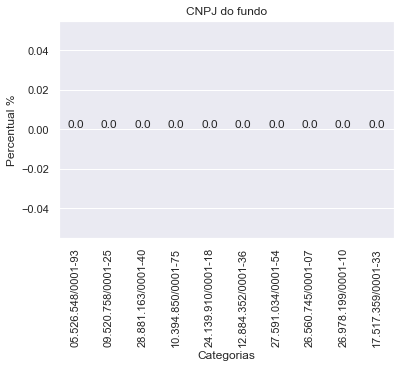

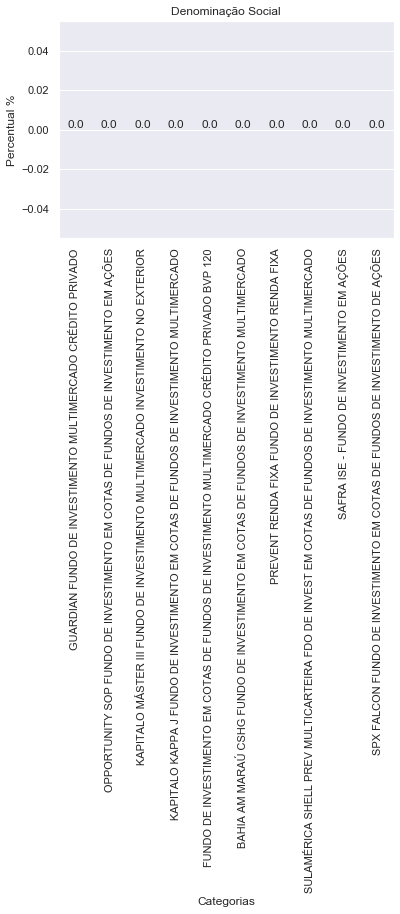

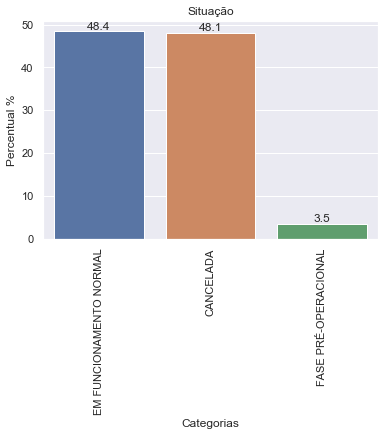

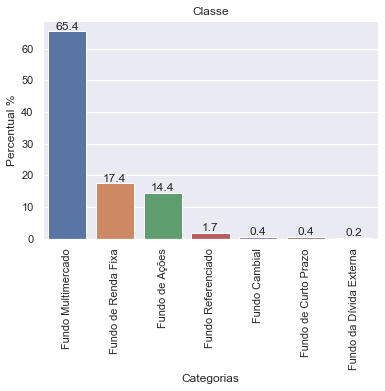

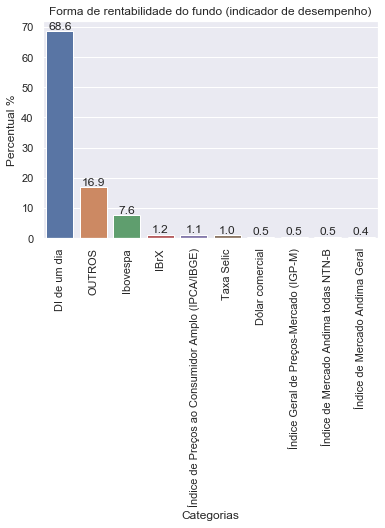

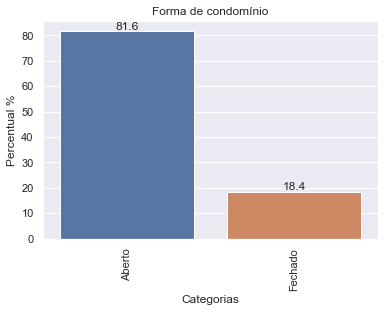

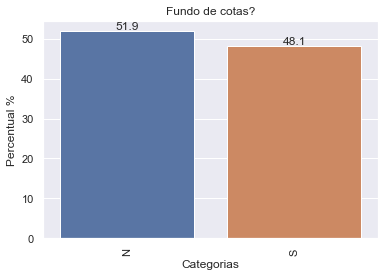

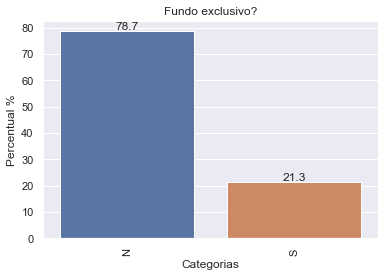

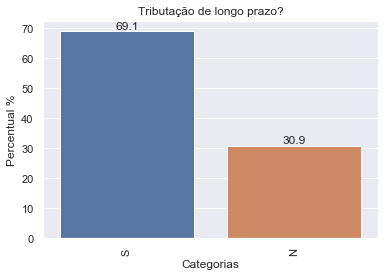

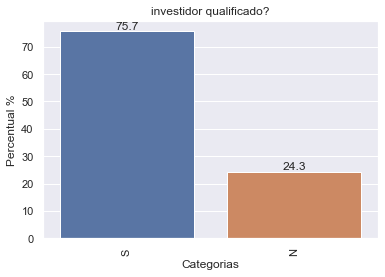

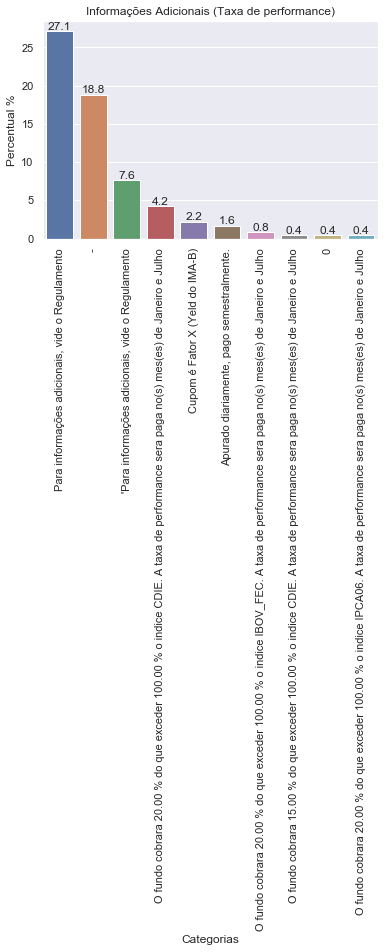

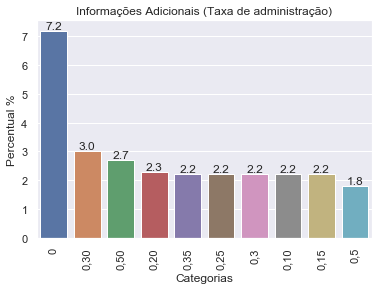

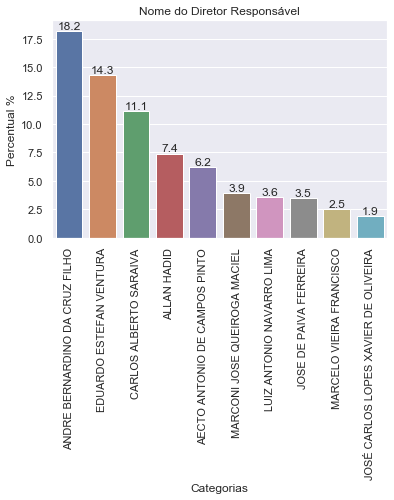

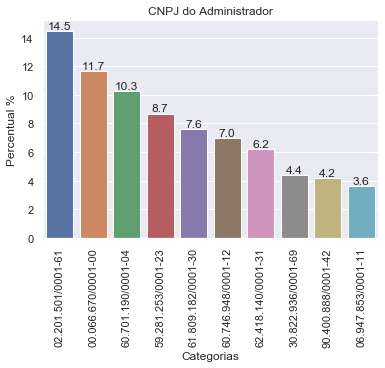

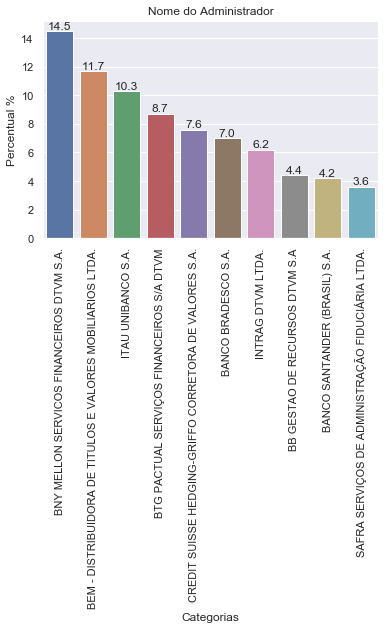

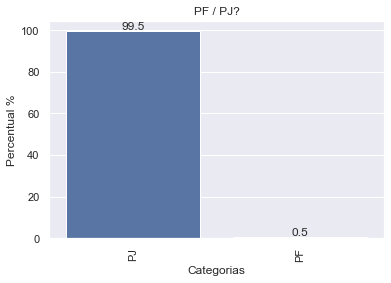

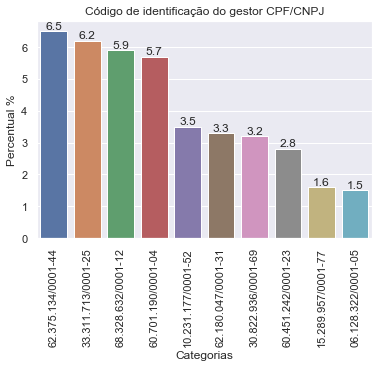

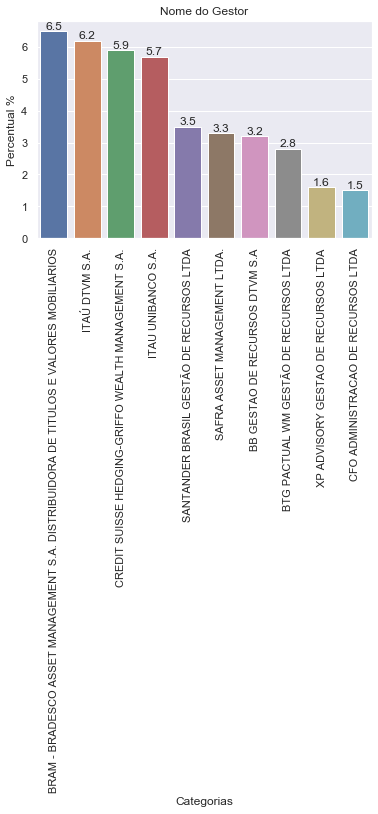

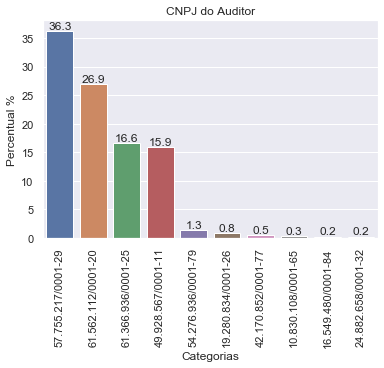

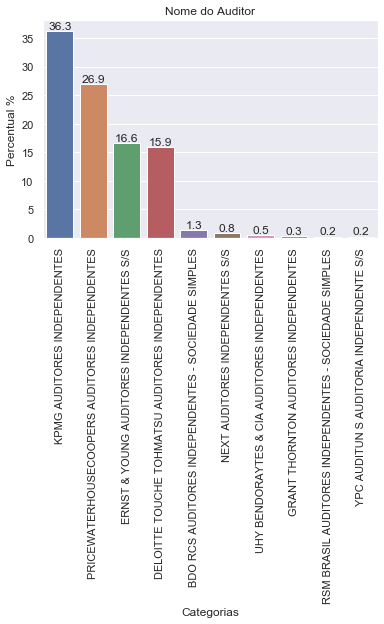

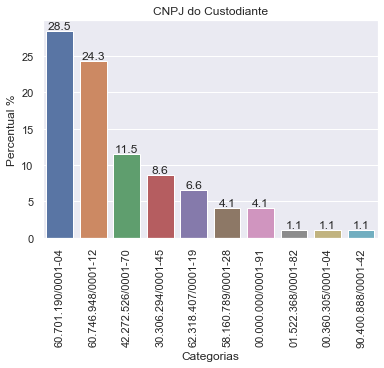

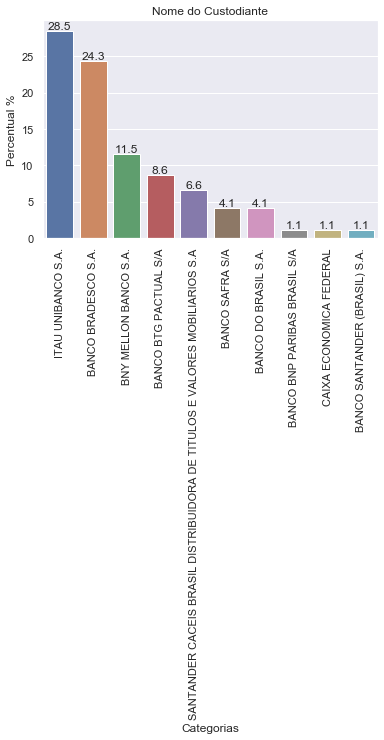

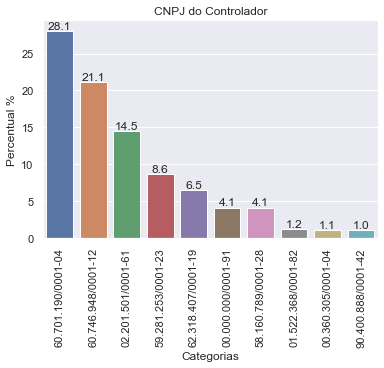

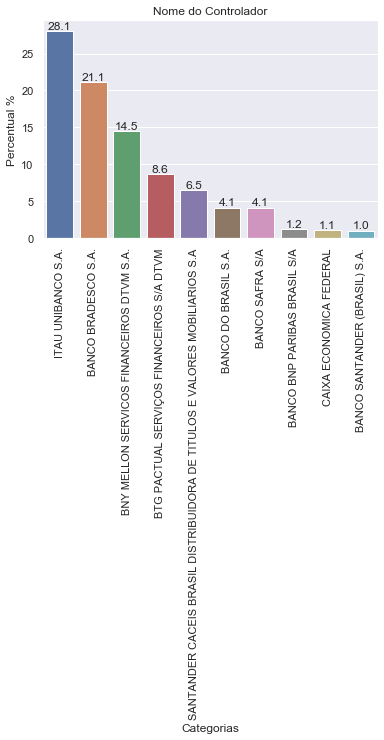

In [17]:
sns.set(style='darkgrid')
for column in dist_freq_cat.keys():
    fig = plt.figure()
    aux = dist_freq_cat[column].nlargest(10)
    g = sns.barplot(x = aux.keys(), y = aux.values, data = pd.DataFrame(aux))
    g.set_xticklabels(rotation=90, labels = aux.keys())
    plt.xlabel('Categorias')
    plt.ylabel('Percentual %')
    for i, v in enumerate(aux):
        g.text(i, v, round(v,2),  horizontalalignment='center', verticalalignment='bottom')
    plt.suptitle(column)

    
plt.show()
#plt.close('all')

<p> Realmente imagens (ou gráficos) dizem mais do que mil palavras! Começamos a aprofundar nossos insights com os gráficos de frequência por atributo / coluna, e vamos analisá-los com calma a partir de agora </p>

<p> Ao plotarmos gráficos de todas as variáveis, nem todos apresentarão informações relevantes e/ou claras devido a sua estrutura. Por exemplo, os gráficos de "CNPJ do fundo" e "Denominação social" não nos geram qualquer insight visto o elevado percentual de valores únicos (98.261% e 98.132%, respectivamente). Descartaremos então estes gráficos e vamos analisar os demais. </p>

<p> O gráfico de "Situação" indica que o dataset é dividido quase igualitariamente entre fundos em funcionamento normal e os cancelados (48,4% e 48,1%), com uma pequena fração em fase pré-operacional (3,5%). A quantidade de fundos de cotas é um pouco menor (48,1%) quando comparado ao de FI's (51,9%). Já quanto a "Forma de condomínio", a vasta maioria é composta por fundos abertos (81,6%) frente a fundos fechados (18,4%). O mesmo padrão é observado quanto aqueles fundos que não são exclusivos (78,7%) frente aqueles que o são (21,3%), assim como os grupos de fundos destinados a investidores qualificados (75,7%) ou não (24,3%). Poderemos entender se estas variáveis se relacionam ("Forma de condomínio", "Fundo exclusivo?" e "Investidor qualificado?") ao analisá-las em conjunto mais a frente.
    
<p> Analisemos agora os prestadores de serviços para a indústria de fundos de investimento. Apesar de informativos, descartaremos os gráficos que apresentam o CNPJ no eixo x (de "Categorias") como em "CNPJ do Gestor", "CNPJ do auditor" e "CNPJ do administrador" para analisar apenas os respectivos gráficos com nomes, por serem mais auto-explicativos. Comecemos pelos administradores. Os 10 maiores participantes detêm 78,2% dos fundos do dataset, com a liderença da BNY Mellon em 14,5%, seguida pela BEM Distribuidora com 11,7% e o Itaú com 10,3%. Quando observamos os gestores, a indústria já é menos concentrada, com os 10 maiores perfazendo 40,19% dos fundos, com o maior percentual em 6,5% por parte da Bradesco Asset Management, 6,2% da Itaú DTVM e 5,9% da Credit Suisse Hedging Griffo. Po outro lado, quando observamos os auditores a concetração é muito maior, com 95,7% dos fundos auditados por Big Fours, com a liderança da KPMG com 36,3%, seguida pela PWC (26,9%), EY (16,6%) e Deloitte (15,9%)

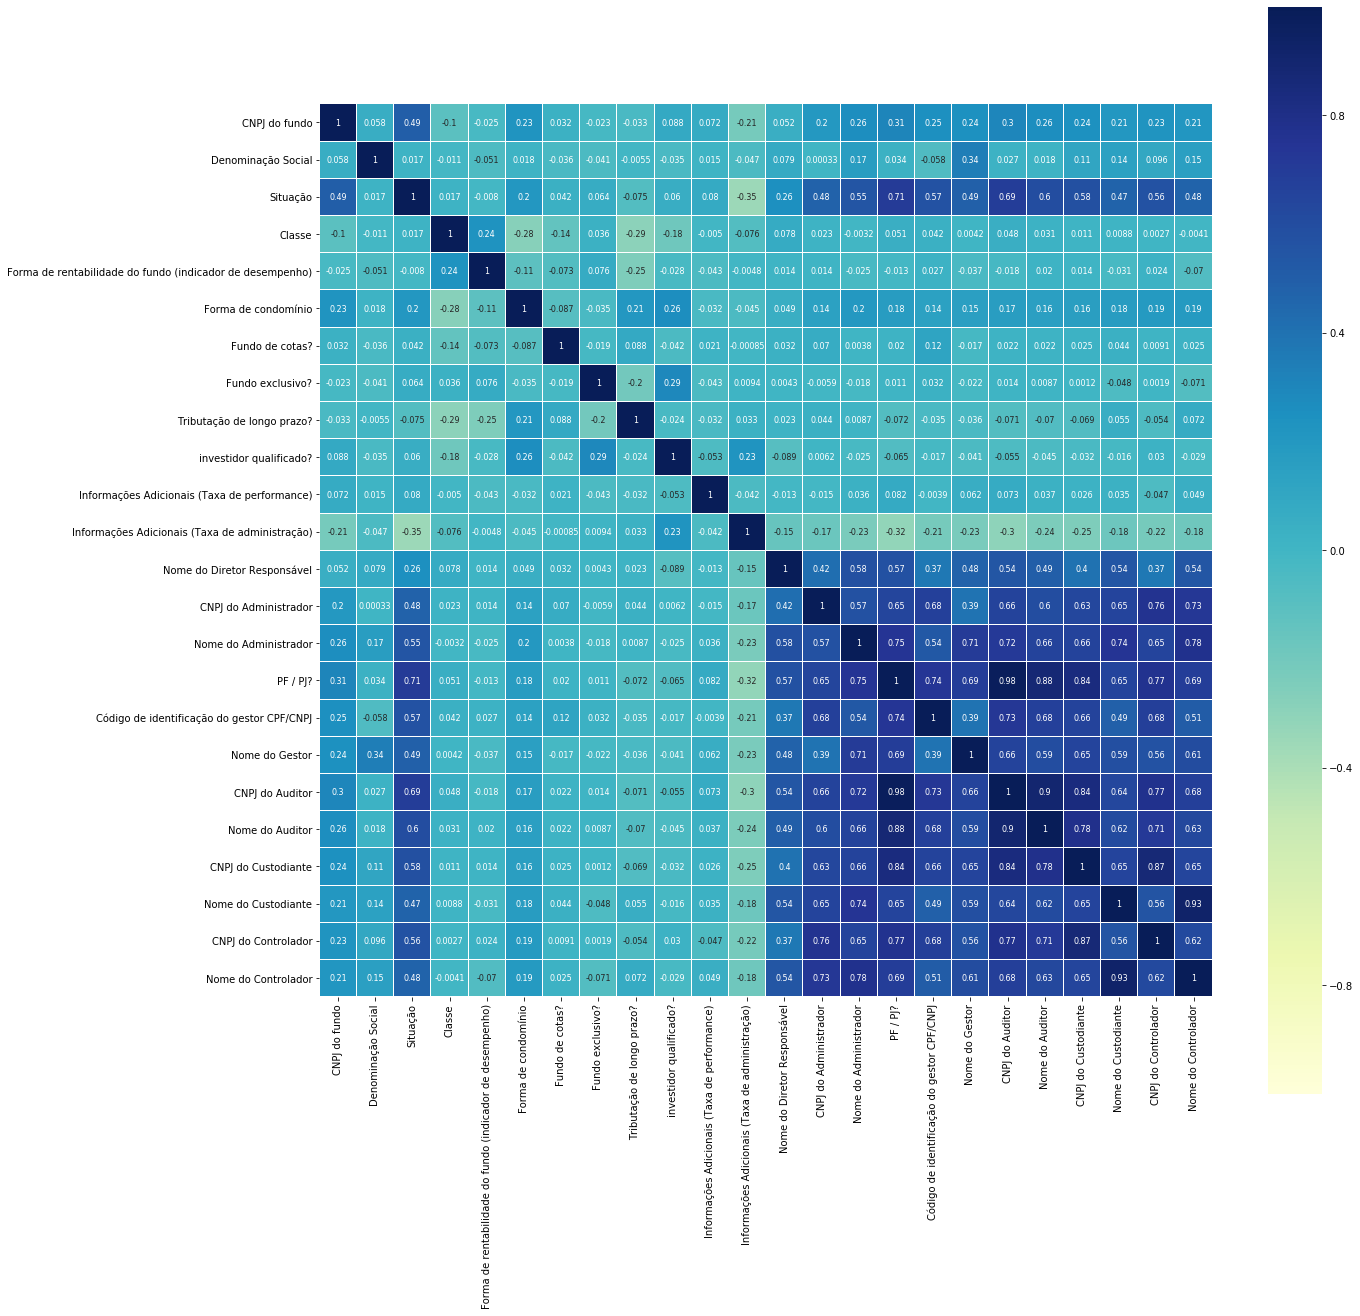

In [32]:
temp_cat = cat_df.astype('category')

for coluna in temp_cat.columns:
    temp_cat[coluna] = temp_cat[coluna].cat.codes
    
correlação = temp_cat.corr()

fig = plt.figure(figsize = (20,20))
#plt.tight_layout()
sns.heatmap(data = correlação, cmap='YlGnBu', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)  

plt.show()

In [33]:
strong_corr = correlação.stack()[(correlação.stack() > 0.5) | (correlação.stack() < -0.5)]

# Cria um set de tuples de todas as duplas de correlação que satisfaçam a condição anterior

strong_corr = set(strong_corr.index)

# Set de tuples apresenta valores duplicados devido a natureza do heatmap (variáveis se cruzam 2 vezes). Código a seguir retira as duplas
# de variáveis idênticas (x e x; corr = 1) e as duplas em dobro (x e y = y e x)

cor_list = []    
for k, f in strong_corr:
    if (k == f):
        continue
    else:
        if((f, k) not in cor_list):
            cor_list.append((k, f))

In [39]:
print(cor_list[:10])

[('Nome do Auditor', 'Situação'), ('Código de identificação do gestor CPF/CNPJ', 'CNPJ do Custodiante'), ('CNPJ do Auditor', 'Nome do Gestor'), ('CNPJ do Administrador', 'Nome do Controlador'), ('PF / PJ?', 'CNPJ do Auditor'), ('CNPJ do Auditor', 'Nome do Controlador'), ('Nome do Custodiante', 'Nome do Administrador'), ('Nome do Auditor', 'PF / PJ?'), ('Situação', 'Código de identificação do gestor CPF/CNPJ'), ('CNPJ do Administrador', 'Código de identificação do gestor CPF/CNPJ')]


In [ ]:
# Obtêm as colunas que fazem que fazem parte das correlações mais fortes, para plotar heatmap apenas com elas           

cols_unicas_strong_corr = []
for k, f in strong_corr:
    if (k == f):
        continue
    else:
        cols_unicas_strong_corr.append(k)
        cols_unicas_strong_corr.append(f)

cols_unicas_strong_corr = set(cols_unicas_strong_corr)

In [34]:
print(cols_unicas_strong_corr)

{'CNPJ do Administrador', 'Nome do Diretor Responsável', 'Nome do Auditor', 'CNPJ do Auditor', 'Código de identificação do gestor CPF/CNPJ', 'Nome do Gestor', 'Situação', 'PF / PJ?', 'Nome do Custodiante', 'Nome do Administrador', 'CNPJ do Controlador', 'CNPJ do Custodiante', 'Nome do Controlador'}


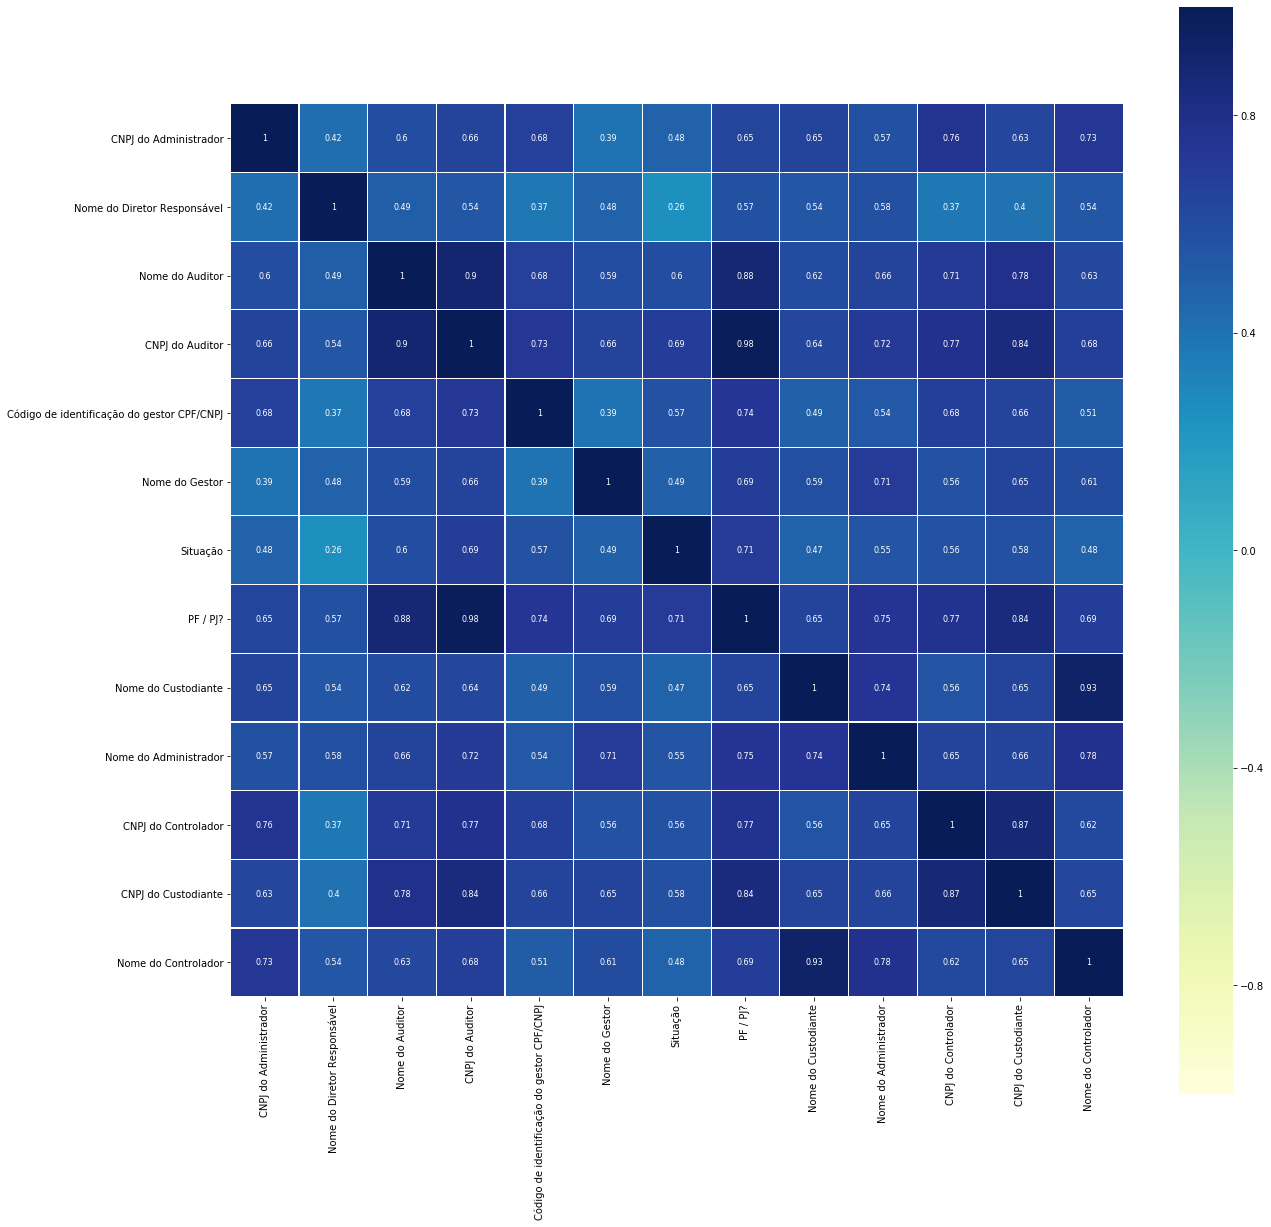

In [36]:
correlação_mais_forte = temp_cat[cols_unicas_strong_corr].corr()

fig = plt.figure(figsize = (20,20))
sns.heatmap(data = correlação_mais_forte, cmap='YlGnBu', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True) 

plt.show()

### 3.3 - Variáveis numéricas

<p> Vamos analisar agora as variáveis numéricas do dataset. </p>

<p> Vamos relembrar quais são: </p>

In [34]:
pd.DataFrame(num_df.columns, columns = ["Colunas"])

,Colunas
0,Taxa de performance
1,Taxa de administração
2,Valor do patrimônio líquido


<p> Este dataset em específico apresenta poucas variáveis numéricas devido a sua própria natureza e objetivo, que é o de elencar as característcas dos fundos de investimento brasileiros. Pr isso o mesmo apresenta uma quantidade de variáveis categóricas muito maior que a de numéricas. Mas isto não é um problema, teremos oportunidade de analisar outros datsets com mais dados numéricos para explorar, </p>

<p> Para um entendimento inicial sobre este tipo de variável o método .describe() é bastante interessante. O mesmo nos apresenta um resumo com 8 informações, como a quantidade de observações, o maior e o menor valor, a média, o desvio-padrão, e o 25º, 50º (ou mediana) e 75º percentil. </p>

<p> O código abaixo realiza estes cáluclos para as 3 variáveis numéricas e apresenta o resultado para a variável "Valor do patrimônio líquido". </p>

In [75]:
num_df.describe().round(2)

,Taxa de performance,Taxa de administração,Valor do patrimônio líquido
count,21605.00,21815.00,3.404600e+04
mean,6.07,96.76,2.495625e+08
std,75.15,4557.71,2.328785e+09
min,0.00,0.00,-2.536335e+06
25%,0.00,0.12,0.000000e+00
50%,0.00,0.45,9.007892e+06
75%,10.00,1.08,5.915163e+07
max,10000.00,450000.00,2.031036e+11


<p> A seguir vamos analisar em um mesmo gráfico a distribuição dos valores para cada varável e se / como as mesmas se relacionam.</p>

<Figure size 432x288 with 0 Axes>

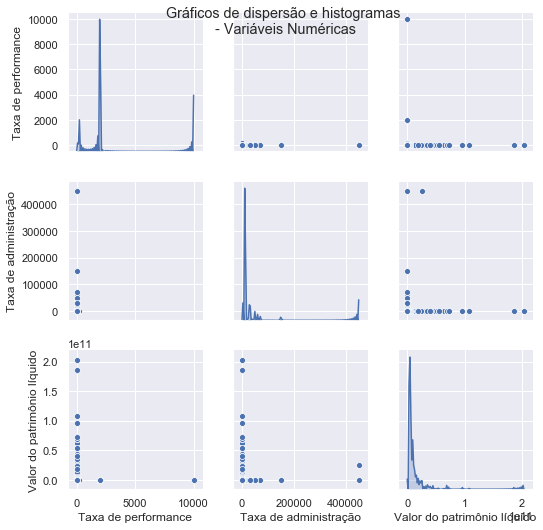

In [73]:
sns.set(style='darkgrid')
fig = plt.figure()
g = sns.pairplot(num_df, diag_kind='kde')
plt.suptitle("Gráficos de dispersão e histogramas \n- Variáveis Numéricas")
plt.show()

<p> Os histogramas (na diagonal) mostram que que as sistribuições das variáveis são bastante enviesadas para a esquerda, enquanto os gráficos de dispersão indicam que as 3 variáveis talvez não tenham uma relação clara. </p>

<p> Podemos atestar isso ao calcular os coeficientes de correlação entre as mesmas e apresentar em um outro gráfico. </p>

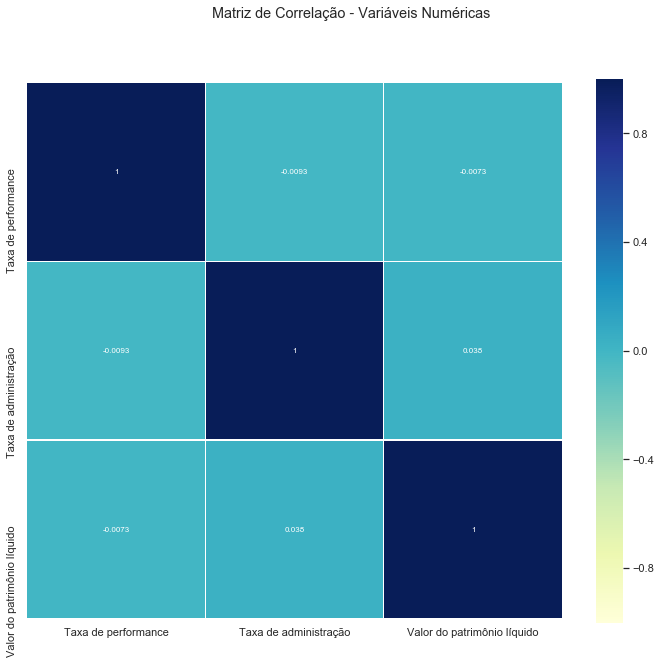

In [69]:
correlation = num_df.corr()
plt.figure(figsize=(12, 10))
plt.suptitle("Matriz de Correlação - Variáveis Numéricas")
sns.heatmap(data = correlation, cmap='YlGnBu', vmax=1.0, vmin=-1.0, linewidths=0.1,
         annot=True, annot_kws={"size": 8}, square=True)

<p> Os valores muito próximos de zero dos coeficientes de correlação </p>

<p> por fim, vamos observar como ficam os gráficos boxplot para tais variáveis numéricas </p>

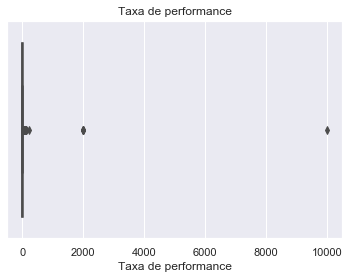

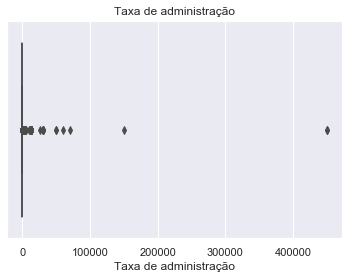

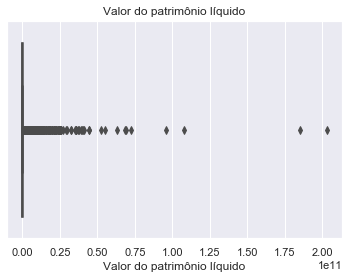

In [65]:
sns.set(style='darkgrid')
for column in num_df.columns:
    fig = plt.figure()
    g = sns.boxplot(num_df[column])
    plt.title(column)

plt.show()

In [ ]:
############ Outliers ################

In [60]:
q = info_cadastral_555[['Valor do patrimônio líquido', 'Classe']].groupby(['Classe']).sum()

In [62]:
q.round(2)

,Valor do patrimônio líquido
Classe,
Fundo Cambial,9.903983e+09
Fundo Multimercado,2.662986e+12
Fundo Referenciado,3.059379e+10
Fundo da Dívida Externa,1.128472e+09
Fundo de Ações,5.825481e+11
Fundo de Curto Prazo,2.327407e+10
Fundo de Renda Fixa,5.186161e+12


In [50]:
q.index

Index(['Fundo Cambial', 'Fundo Multimercado', 'Fundo Referenciado',
       'Fundo da Dívida Externa', 'Fundo de Ações', 'Fundo de Curto Prazo',
       'Fundo de Renda Fixa'],
      dtype='object', name='Classe')

In [56]:
q.values

array([[9.90398349e+11],
       [2.66298648e+14],
       [3.05937949e+12],
       [1.12847174e+11],
       [5.82548111e+13],
       [2.32740669e+12],
       [5.18616074e+14]])

## 4 - Apêndice - Panorama da Indústria em 30/04/2020